In [1]:
#import importlib
import claims_over_time_plot
import get_data
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter, FormatStrFormatter, StrMethodFormatter 
#\from isoweek import Week
import os
#importlib.reload(get_data)
#importlib.reload(bayes_model_summary)


In [2]:
from get_data import get_data,get_data_withcovid, fix_dates
import pandas as pd
from claims_over_time_plot import summarize
# from bayes_estimate import estimate_regression
import gc

In [3]:
def format_atts(use_gpi='covid'):
    atts = pa.read_csv("../Processed Data/regression/IVM_Regression_Dataset_per_untransformed_claim_False_" + use_gpi + ".csv")
    
    atts = fix_dates(atts)
    
    atts.fillna(0, inplace=True)
    atts = atts.groupby(["time_index", "week_date"], as_index=False).sum()
    covid_cases = atts["cases"].values / 1000000

    return atts, covid_cases

In [4]:
def format_xaxis(ax,  labels, end_time_index, tick_spacing):
    """
    Handles x axis labels precisely
    ax is the axes from ax, plt
    positions - list of integers that directly map to each xtick. Play with this to define which ticks to show.
    labels  -  a list to index indices from positions. 
    returns ax
    """

    positions = [ x for x in range(0, end_time_index,tick_spacing)]+[end_time_index]

    ax.xaxis.set_major_locator(MaxNLocator(len(positions)))
    ax.xaxis.set_ticks(positions)
    ax.xaxis.set_ticklabels([ labels[x] for x in positions],rotation=90)
    return ax

def format_yaxis(ax, rounding='integer'):
    if rounding=='integer':
        ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

    else:
        ax.set_yticklabels(['{:,}'.format(pa.np.round(x,2)) for x in ax.get_yticks().tolist()])
    return ax


def main_graph(y_all, vlinepos, covid_cases, title="", y_label="", covid_label="", use_gpi="covid", xname='Weeks', opath='./graphs/',suffix='', time_labels=[], drug_name="hydroxychloroquine", treat_pos=0):
    
    
    font = {'family' : 'Times New Roman',
            'size'   : 14}
    plt.rc('font', **font)

    fig, ax = plt.subplots(figsize=(15,8))

    
    tick_spacing=4

    colors= ['black','blue',"red","green",'yellow','brown','aqua','darkgreen']
    
    colors_= ['black',"green",'purple','saddlebrown','midnightblue','orange','forestgreen','sandybrown','midnightblue']
    
    from important_dates import get_time_indices
    
    event_lines = get_time_indices(drug=drug_name)
    
    y_max = max(y_all)
    y_min = min(y_all)
    
    
    """
    if drug_name=='hydroxychloroquine' or drug_name=='chloroquine phosphate':
        y_max=70
    elif drug_name=='ivermectin':
        y_max=400
    """
    labels_ = time_labels
    
    trend_ = [x for x in range(len(time_labels))]
    
    time = trend_
    end_time_index = max(trend_)


    #time = pa.to_datetime(time.values)
    if drug_name == "hydroxychlroquine":
        ax.plot_date(time, y_all, lw =1.5, color=colors[2], label = 'Actual HCQ Claims', linestyle="-", marker='')
    
    elif drug_name == "ivermectin":
        ax.plot_date(time, y_all, lw =1.5, color=colors[2], label = 'ATT', linestyle="-", marker='')
    
    # y_max = 1205
    # y_min = 430
    
    y_pos = y_max * 0.75 + y_min * 0.25
    print("y pos", y_pos)
    
    
    
    for ix,vl in enumerate(list(event_lines)): 
        if vl > labels_[0]:
            vline_position = labels_.index(vl)
            print(vline_position)
            ax.axvline(vline_position, color=colors_[ix], linestyle='--',  label=event_lines[vl], lw=2)
            ax.annotate("Event " + event_lines[vl].split(":")[0], xy =(vline_position-1.5, y_pos), rotation=90 , fontsize=14)

    if drug_name == "hydroxychloroquine":
        if "placebo" not in suffix:
            treatment_label = "Treatment Date:\nDidier Raoult posts his video about HCQ"    
            ax.vlines(treat_pos, ymin=np.min(y_all), ymax=y_max, color='black', linestyle='--', label=treatment_label, lw=2)
        else:
            actual_treatment_ix = 59
            treatment_label = "Placebo Treatment Date"    
            ax.vlines(treat_pos, ymin=np.min(y_all), ymax=y_max, color='darkred', linestyle='--', label=treatment_label, lw=2)

            treatment_label = "Actual Treatment Date:\nDidier Raoult posts his video about HCQ"    
            ax.vlines(actual_treatment_ix, ymin=np.min(y_all), ymax=y_max, color='black', linestyle='--', label=treatment_label, lw=2)

    #ax.xaxis.set_ticks(np.array(time)[::5])
    ax.set_xlabel('Week (Sunday)', font=font)
    ax.xaxis.labelpad = 20

    ax.tick_params(axis='x', rotation=90)
    
    ax.tick_params(axis='y', labelsize=14)

    ax.yaxis.labelpad = 5
    ax.set_ylabel(y_label, font=font)
    
    ax.set_title(title, fontdict={"fontsize" : 18, "fontweight" : "bold", "fontfamily":"Times New Roman"})

    ax = format_xaxis(ax,  time_labels, end_time_index, tick_spacing)
    if y_all.mean() > 1:
        ax = format_yaxis(ax)
    font2 = {'family' : 'Times New Roman',
           'size'   : 14}
    fig.legend(loc='upper center', ncol=4, prop=font2, bbox_to_anchor=(0.5, -0.05))

    
    if not os.path.exists('{}'.format(opath)):
        os.makedirs('{}'.format(opath))
    print("FILEPATH",'{}/{}'.format(opath,suffix )+'.png')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(covid_label, font=font)  # we already handled the x-label with ax1
    ax2.plot_date(time, covid_cases, color = colors[1], lw =1, linestyle='--',marker='', label="Weekly Covid Cases per 1,000,000 People")
    ax2.yaxis.labelpad = 5
    if covid_cases.mean() > 1:
        ax2 = format_yaxis(ax2)
    ax2.xaxis.set_ticks(np.array(time))
    ax2.set_xlabel('Week (Sunday)', font=font)
    ax2.xaxis.labelpad = 20
    ax2.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', rotation=90, labelsize=14)
    ax2.xaxis.set_ticks(np.array(time))
    fig.legends = []
    fig.legend(loc='upper center', ncol=3, prop=font2, bbox_to_anchor=(0.5, -0.05))
    fig.savefig("graphs/ivm_att_over_time_" + use_gpi + ".png",bbox_inches='tight',dpi=300)
    
    return 


/tmp/ipykernel_3472148/3447168092.py:69: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time, y_all, lw =1.5, color=colors[2], label = 'ATT', linestyle="-", marker='')
/tmp/ipykernel_3472148/3447168092.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
/tmp/ipykernel_3472148/3447168092.py:125: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(time, covid_cases, color = colors[1], lw =1, linestyle='--',marker='', label="Weekly Covid Cases per 1,000,000 People")


y pos 72056.91205974376
36
41
44
48
65
67
73
FILEPATH ./graphs//.png


/tmp/ipykernel_3472148/3447168092.py:69: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time, y_all, lw =1.5, color=colors[2], label = 'ATT', linestyle="-", marker='')
/tmp/ipykernel_3472148/3447168092.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
/tmp/ipykernel_3472148/3447168092.py:125: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(time, covid_cases, color = colors[1], lw =1, linestyle='--',marker='', label="Weekly Covid Cases per 1,000,000 People")


y pos 71933.80724001088
36
41
44
48
65
67
73
FILEPATH ./graphs//.png


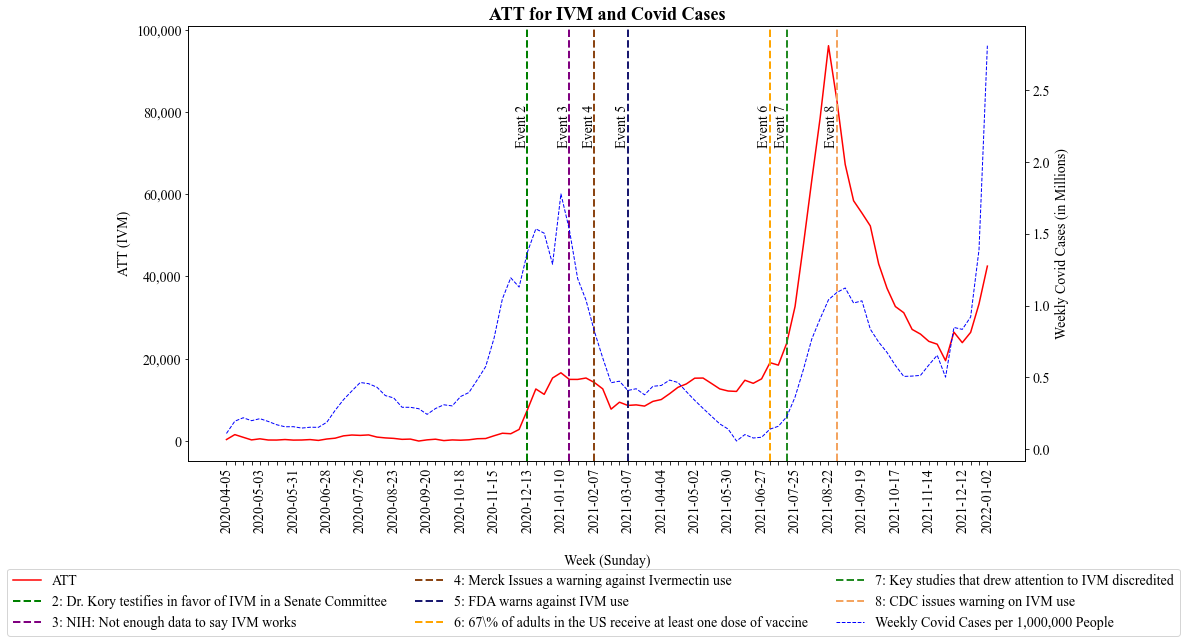

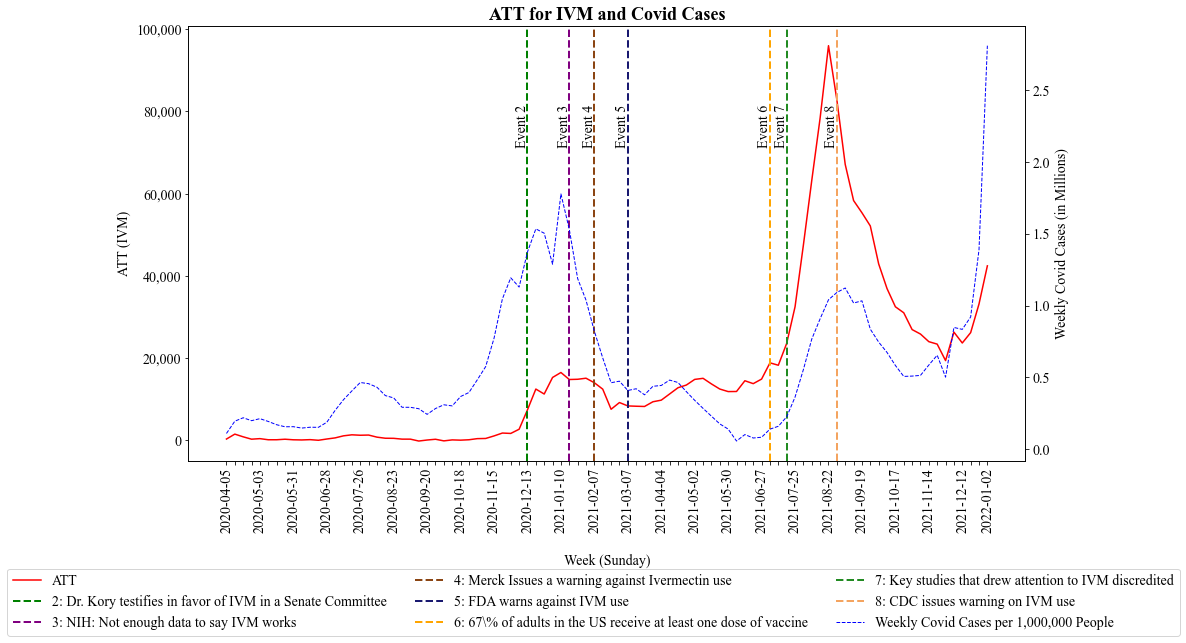

In [5]:
for use_gpi in ["covid", "gpi"]:
    atts, covid_cases = format_atts(use_gpi=use_gpi)
    
    title="ATT for IVM and Covid Cases"
    y_label="ATT (IVM)"
    covid_label="Weekly Covid Cases (in Millions)"
    
    time_labels = atts.week_date.to_list()
    main_graph(y_all=atts.att, vlinepos=None, covid_cases=covid_cases, title=title, y_label=y_label, covid_label=covid_label, use_gpi=use_gpi, time_labels=time_labels, drug_name='ivermectin')